In [ ]:
import pandas as pd
import numpy as np
import os

datapath = '../'
filename = 'BRAZPD_UnofM_all.csv'
filename = os.path.join(datapath,filename)

df = pd.read_csv(filename, engine='python')

In [ ]:
display(df)

# Data Cleaning

In [ ]:
import re

nMeasurements = 75
nColumns = 1735
nRecords = 5707
timeseries_names = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
              'Hemoglobin', 'Hematocrit','Volume_Total', 'Systolic', 'Diastolic', 'N_AH_']

different_format_ts_names = ['Mes_1_PAS', 'Mes_1_PAD', 'Mes_1_Uso_de_anti_hipert', 'Mes_1_inibidor',\
                             'Mes_1_beta', 'Mes_1_ant', 'Mes_1_diu', 'Mes_1_at_i', 'Mes_1_OUTROS']

# Put timeseries names into standard format
p = re.compile('[0-9]')
strip = re.compile('Mes_[0-9]_')
for timeseries in different_format_ts_names:
    for i in range(1,nMeasurements):
        try:
            old_label = p.sub(str(i), timeseries)
            new_label = strip.sub('',timeseries)
            df[new_label+str(i)] = pd.Series(df[old_label])
            df.drop([old_label],axis=1, inplace=True)
        except:
            print(f'Column {timeseries}{i} does not exist')
    timeseries_names.append(new_label)
    
# make sure we don't have duplicate columns
assert nColumns == df.shape[1]

# Data Exploration

In [ ]:
from matplotlib import pyplot as plt
from collections import defaultdict

plots_folder = "plots/"

nans_count = defaultdict(list)

for timeseries in timeseries_names:
    for i in range(1,nMeasurements):
        try:
            nans_count[timeseries].append(df[timeseries+str(i)].isna().sum())
        except:
            print(f'Column {timeseries}{i} does not exist')


plt.figure(figsize=(12,5))
plt.title("Available records in time")
plt.xlabel("Months")
plt.ylabel("# records")
plt.xlim([0,76])
for timeseries in timeseries_names:
    plt.plot(range(1,len(nans_count[timeseries])+1),5707-np.array(nans_count[timeseries]),label=timeseries,marker='.')
    plt.plot([1,75],[5707,5707],ls='--',color='gray')
plt.legend(ncol=2)
plt.savefig(os.path.join(plots_folder,f"records_per_month.pdf"), bbox_inches='tight')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

endpoints = [1,13,25,37,49,61,73]

for timeseries in timeseries_names:
    fig, axs = plt.subplots(2, 3,figsize=(15,10),sharey=True)
    for year in [1,2,3,4,5,6]:
        x_plot_loc = (year-1)%3
        y_plot_loc = int((year-1)/3)
        axs[y_plot_loc , x_plot_loc].set_title(f"{timeseries} year {year}")
        for i in range(endpoints[year-1],endpoints[year]):
            try:
                df[timeseries+str(i)].plot.hist(bins=20,alpha=0.3,label=f'Month {i}',stacked=True,ax=axs[y_plot_loc , x_plot_loc])
            except:
                print(f'Column {timeseries}{i} does not exist')
        axs[y_plot_loc , x_plot_loc].legend()
    plt.savefig(os.path.join(plots_folder,f"{timeseries}_histogram.pdf"), bbox_inches='tight')

# Build targets and features

In [47]:
targets = ['Dropoutsim1', 'Followup1y', 'Followup2y', 'Followup3y',\
           "death_event_1y","Tech_event_1y",\
           "death_event_2y","Tech_event_2y",\
           "death_event_3y","Tech_event_3y",\
           "Deathevent","TechniqueFailureevent","Causeofdeath","TechFailureDeathnotcens","Causeofdropout",\
           "Followup"]

# build targets dataframe:
Y = df[targets+['CODPAX']].copy()

# build full feature dataframe:
irrelevant_features = ['nome_cidade','DataincioPDNEt','CRTechniqueFailure','CRDeath','Anodesada',\
                       'mesdesaida','anodeentrada','Bienium','Id',\
                       'CR_death_event_1y', 'CR_death_event_2y', 'CR_death_event_3y']

X = df.copy()
try:
    X.drop(columns=irrelevant_features,inplace=True)
except:
    print("Can't drop colums", irrelevant_features)

try:
    X.drop(columns=targets,inplace=True)
except:
    pass

irrelevant_ts = ['beta', 'ant', 'diu', 'at_i', 'OUTROS']
# Put timeseries names into standard format
for timeseries in irrelevant_ts:
    for i in range(1,nMeasurements):
        try:
            X.drop([timeseries+str(i)],axis=1, inplace=True)
        except:
            print(f'Column {timeseries}{i} does not exist')
    

# Making baseline feature sets

In [48]:
baseline_set = ['Hemoglobin', 'Potassium', 'Phosphate',\
                'Mean_PAS_1T', 'Mean_PAD_1T',\
                 'FRR', 'codigoclinica', 'ModalidadeCAPD0APD1Mix2',\
                'CenterSizenpatients', 'ModalidadeDPInicial', 'Age',\
                'BMI', 'IncidentinPD', 'PrevalentinPDNet', \
                'DialysisvintageprePDNet', 'totaldialysisvintage',\
                'Educationlevel', 'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'DM', 'CAD', 'LVH', 'LES', 'HF', 'Cancer', 'Stroke',\
                'Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'Distancefromcenter', 'predialysiscare',\
                'timeofpredialysiscare', 'Agedic65', 'Racedicwhite', 'Educationdic4y',\
                'Daviesdic', 'Incomesdic', 'Region', 'Centerexperiencepatientyear',\
                'Regionsdic', 'cidade', 'BMI_Cat',\
                'BMI_dic']


X_baseline = X[baseline_set].copy()

# Baseline model

In [197]:
def run_model(X_model, y, use_smote=False):
    
    X_model.fillna(0,inplace=True)
    
    k = 10
    kf = StratifiedKFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    list_recall_score = []
    list_precision_score = []
    j = 0
    
    for train_index, test_index in kf.split(X_model,y):
        X_train, X_test = X_model.iloc[train_index,:], X_model.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        X_train = pd.DataFrame(X_train,columns=X_train.columns)
        X_test = pd.DataFrame(X_test,columns=X_test.columns)
        
        if use_smote == True:
            # SMOTE sampling
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=8,
            min_child_weight=5)
        model.fit(X_train, y_train)

        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        shap.summary_plot(shap_values, X_test)
        print(shap_values.shape)
        f1score = f1_score(y_test, y_pred)
        recallscore = recall_score(y_test,y_pred)
        precisionscore = precision_score(y_test,y_pred)
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        list_recall_score.append(recallscore)
        list_precision_score.append(precisionscore)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        
    #bringing back variable names    
    X_test = X_model.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    mean_recall_score = np.mean(list_recall_score)
    mean_precision_score = np.mean(list_precision_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score},\
            mean recall-score: {mean_recall_score}, mean precision-score:{mean_precision_score}")
    
    #for i in range(k):
    #    shap.summary_plot(list_shap_values[i], X_test)
        
    return mean_normalised_accuracy, mean_f1_score, mean_recall_score, mean_precision_score

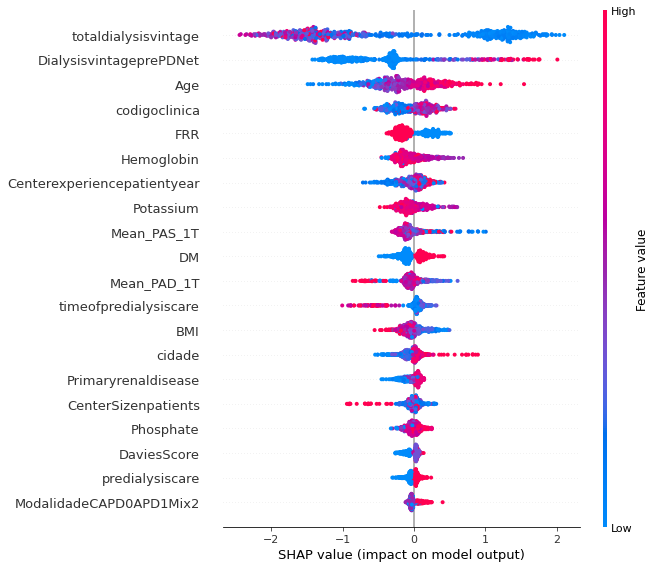

(571, 50)


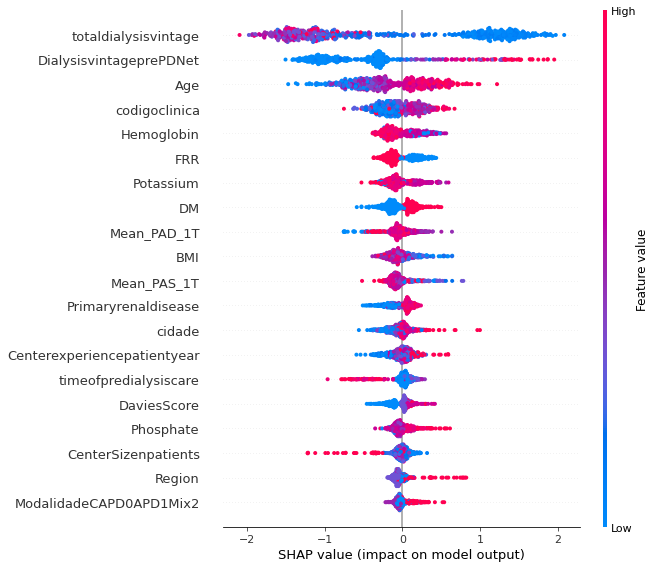

(571, 50)


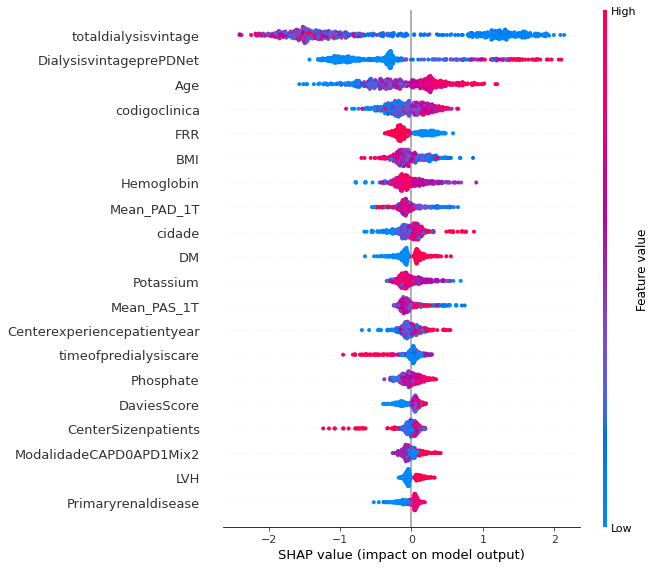

(571, 50)


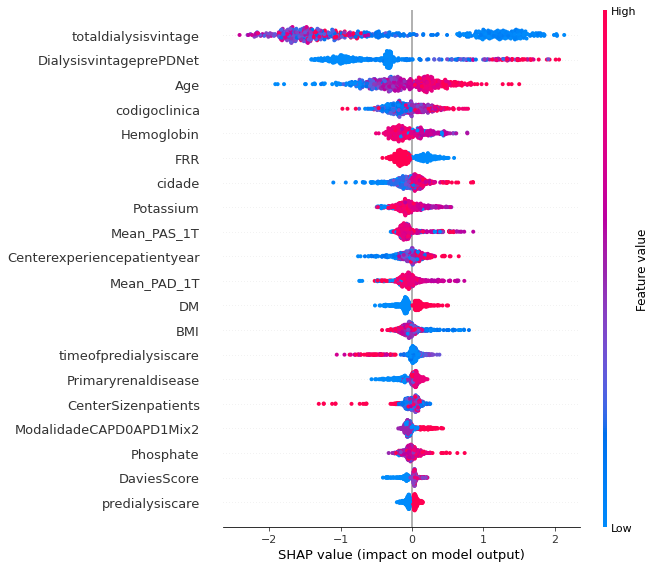

(571, 50)


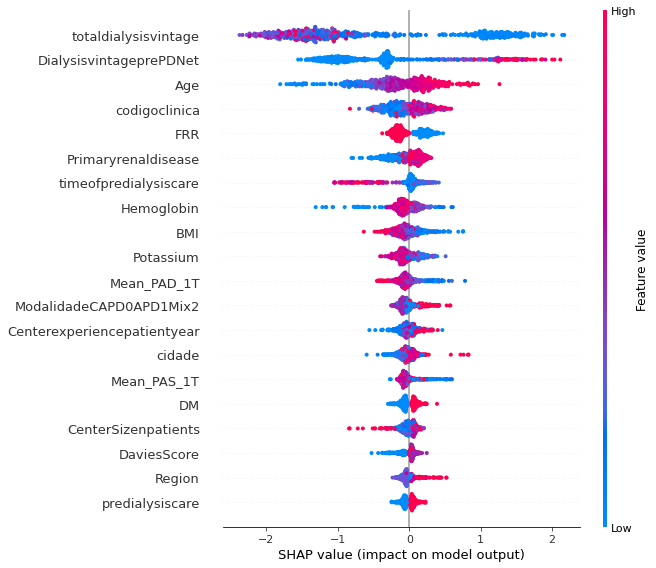

(571, 50)


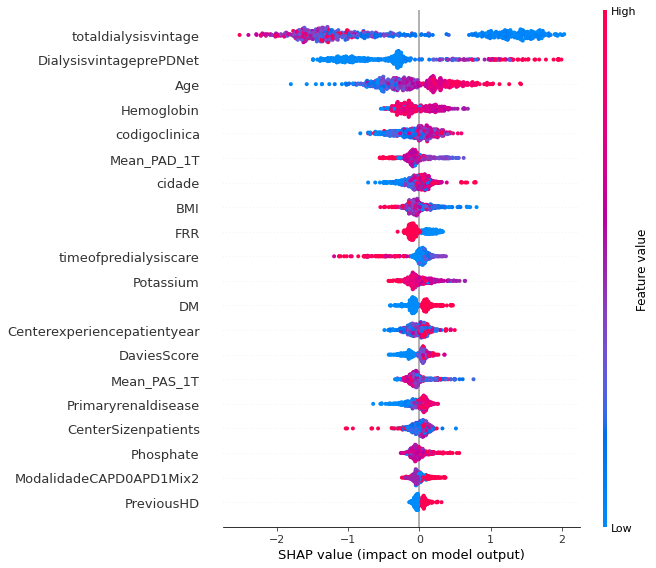

(571, 50)


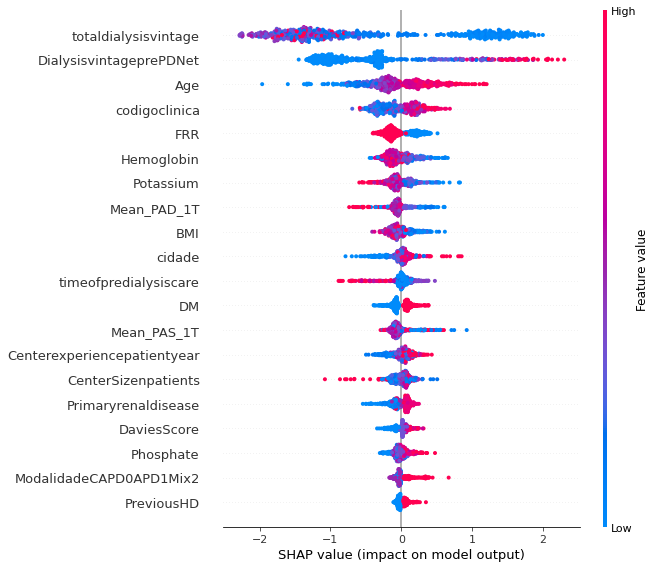

(571, 50)


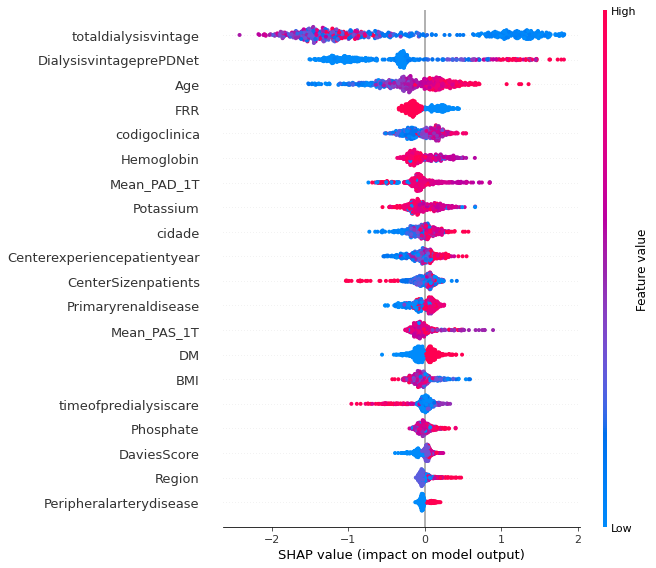

(570, 50)


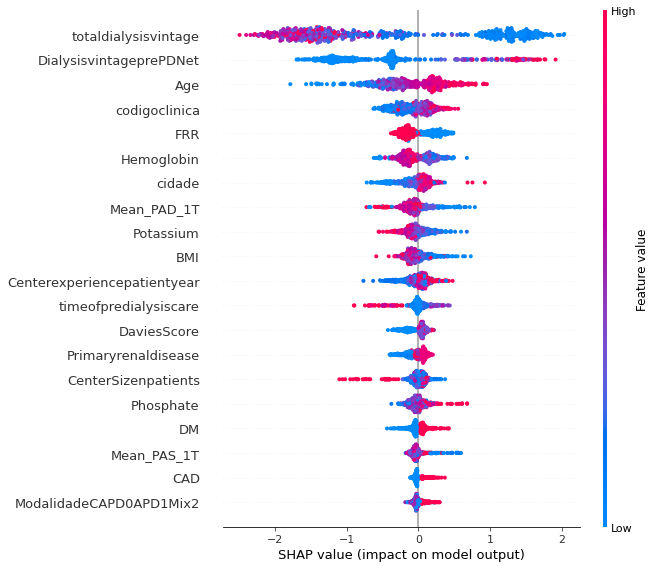

(570, 50)


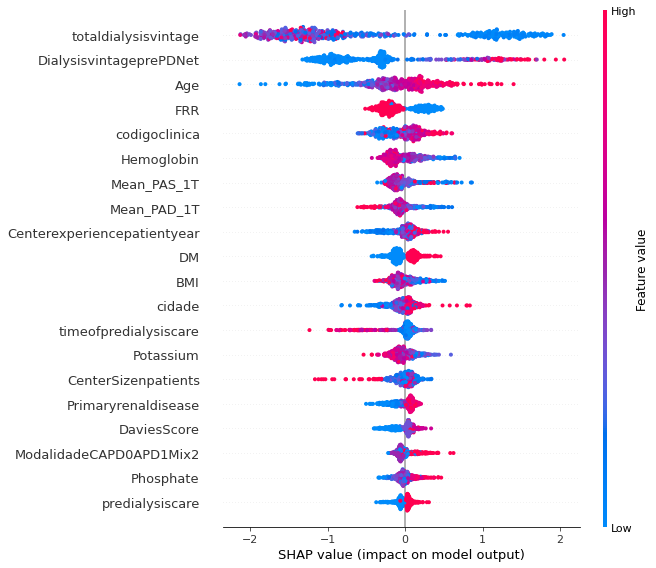

(570, 50)
Target: death_event_1y, mean accuracy: 0.9137871385995637, mean f1-score: 0.2843530644443771,            mean recall-score: 0.1932126696832579, mean precision-score:0.5605081063699318


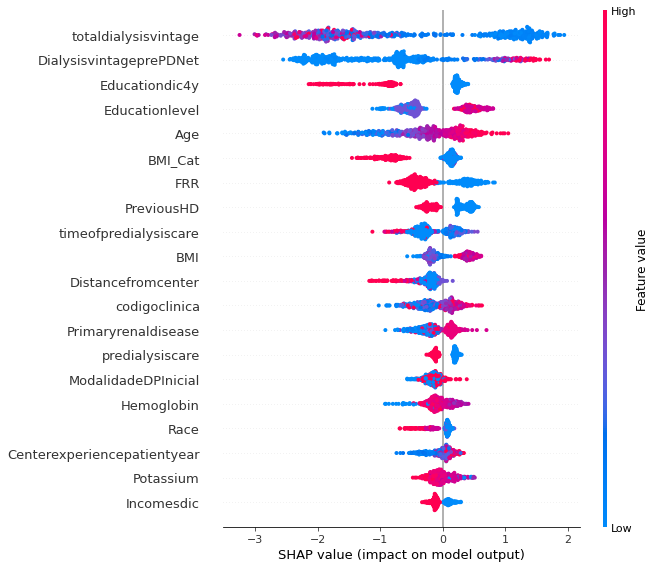

(571, 50)


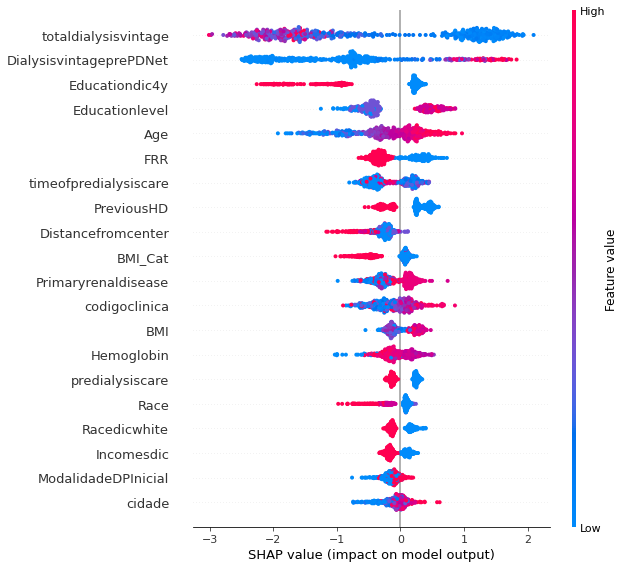

(571, 50)


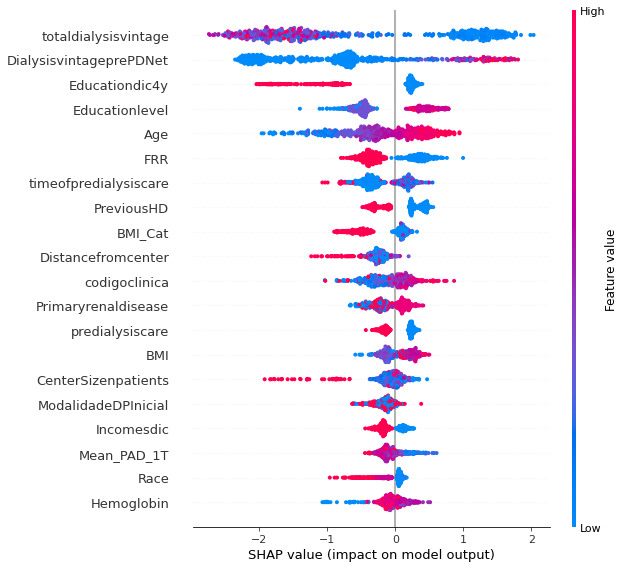

(571, 50)


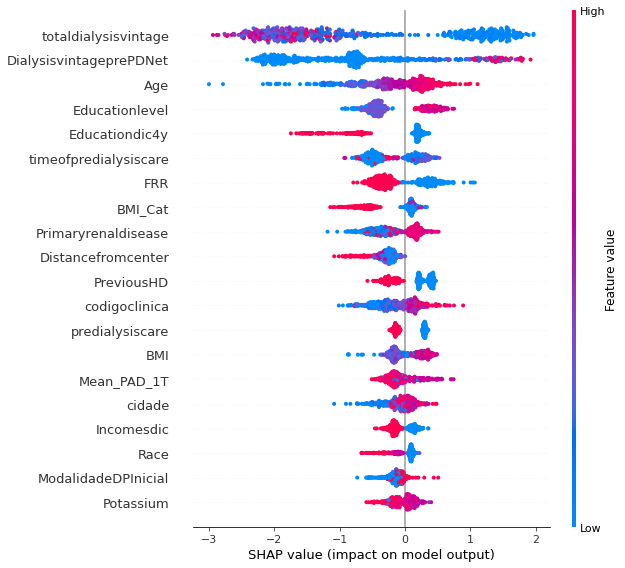

(571, 50)


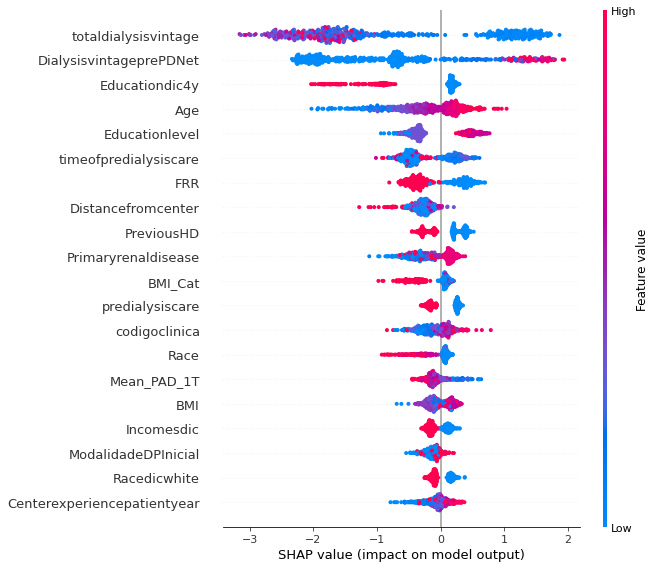

(571, 50)


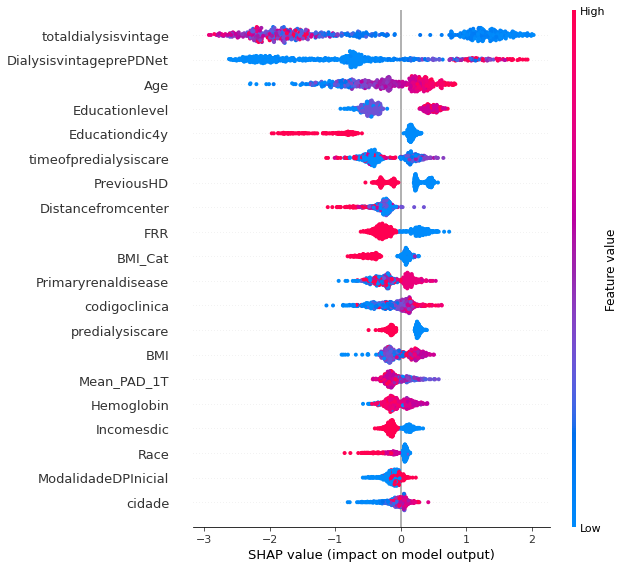

(571, 50)


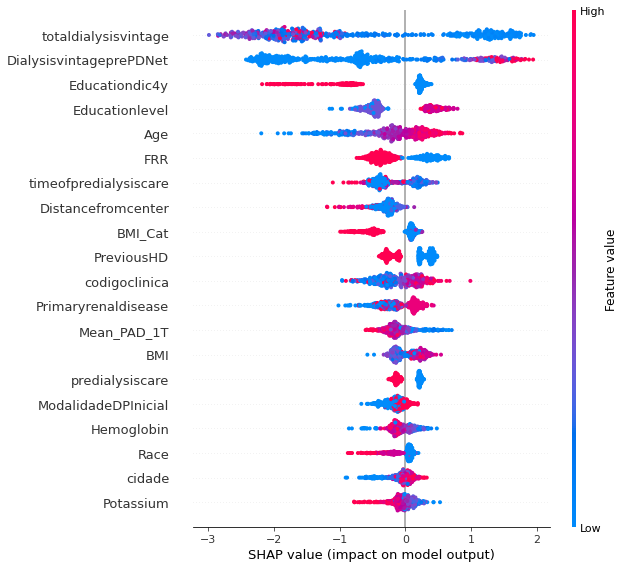

(571, 50)


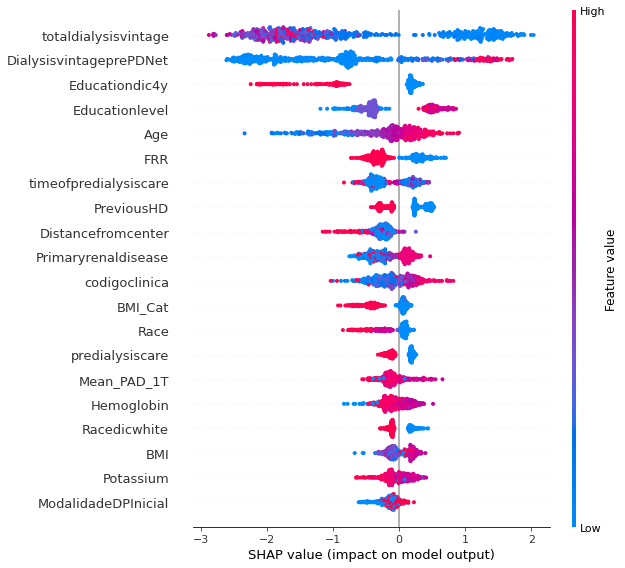

(570, 50)


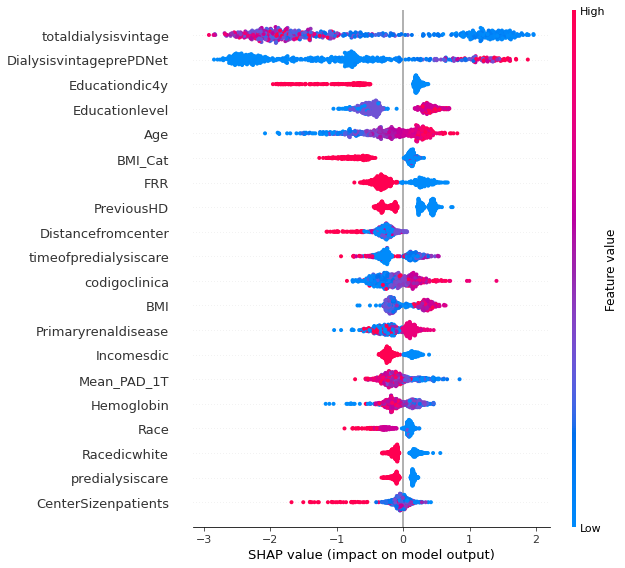

(570, 50)


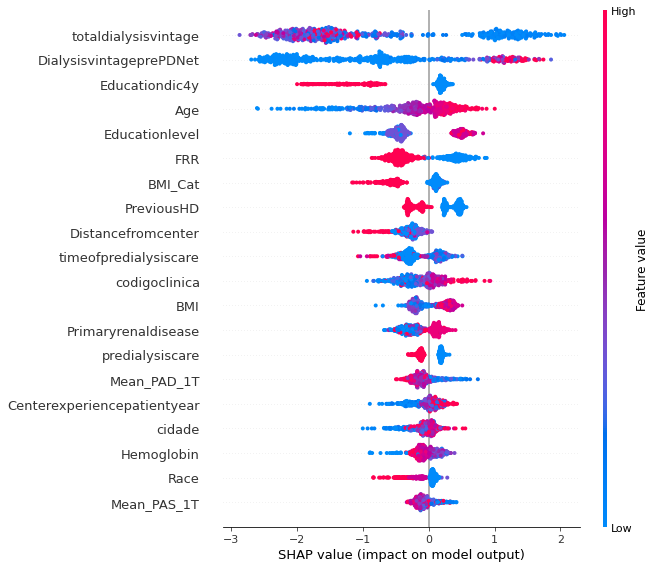

(570, 50)
Target: death_event_1y, mean accuracy: 0.9078342089900758, mean f1-score: 0.3321535323711192,            mean recall-score: 0.2618024132730015, mean precision-score:0.46650458961061425


In [198]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold

from imblearn.over_sampling import SMOTE

targets = ["death_event_1y"]
models = []
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X_baseline.copy()
    
    _,_,_,_ = run_model(X_model,y,use_smote=False)
    _,_,_,_ = run_model(X_model,y,use_smote=True)

# Feature selection

In [199]:
from sklearn.feature_selection import SelectFromModel
from collections import Counter

accum_relevance = Counter()
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X_baseline.copy()
    
    X_model.fillna(0,inplace=True)
    print(X_model.shape)
    for train_index, test_index in kf.split(X_model,y):
            X_train, X_test = X_model.iloc[train_index,:], X_model.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]
            X_train = pd.DataFrame(X_train,columns=X_train.columns)
            X_test = pd.DataFrame(X_test,columns=X_test.columns)
    
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            
            clf = xgboost.XGBClassifier(
                learning_rate =0.1,
                max_depth=8,
                min_child_weight=5)
            clf.fit(X_train, y_train)

            model2 = SelectFromModel(clf, prefit=True)
            X_new = model2.transform(X_model)
            
            importances = zip(list(X_train.columns),clf.feature_importances_)
            for feat_name, feat_imp in importances:
                accum_relevance[feat_name]+=feat_imp

relevant_features = [a for a,b in accum_relevance.items() if b > 0.0]
print(relevant_features)

(5707, 50)
['Hemoglobin', 'Potassium', 'Phosphate', 'Mean_PAS_1T', 'Mean_PAD_1T', 'FRR', 'codigoclinica', 'ModalidadeCAPD0APD1Mix2', 'CenterSizenpatients', 'ModalidadeDPInicial', 'Age', 'BMI', 'DialysisvintageprePDNet', 'totaldialysisvintage', 'Educationlevel', 'Primaryrenaldisease', 'PreviousHD', 'DaviesScore', 'Peripheralarterydisease', 'DM', 'CAD', 'LVH', 'HF', 'Cancer', 'Hypertension', 'Gender', 'Race', 'Familyincome', 'Distancefromcenter', 'predialysiscare', 'timeofpredialysiscare', 'Agedic65', 'Racedicwhite', 'Educationdic4y', 'Daviesdic', 'Incomesdic', 'Region', 'Centerexperiencepatientyear', 'Regionsdic', 'cidade', 'BMI_Cat', 'BMI_dic']


(5707, 42)


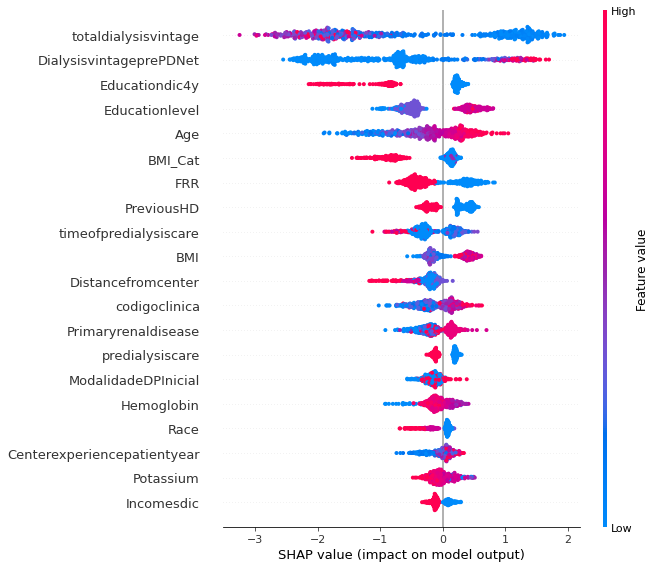

(571, 42)


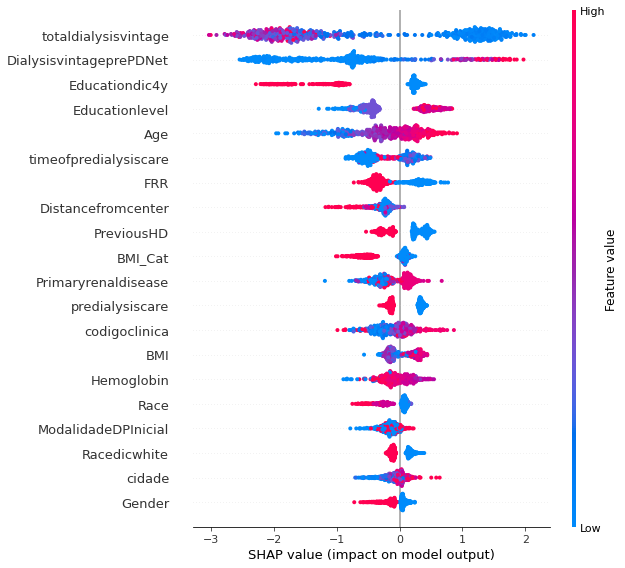

(571, 42)


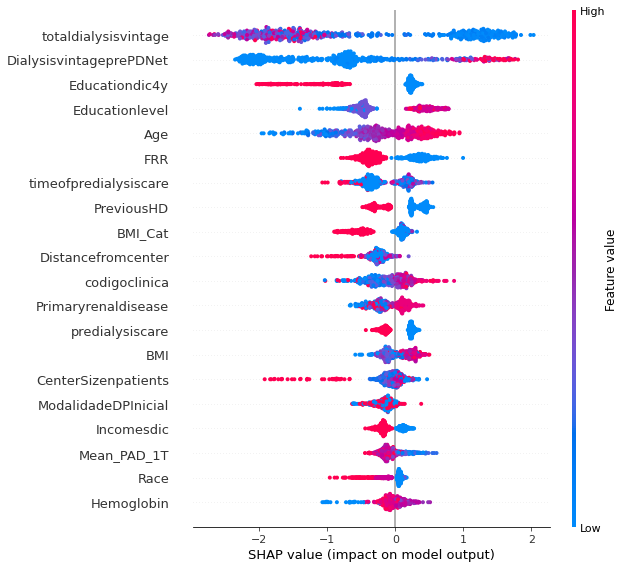

(571, 42)


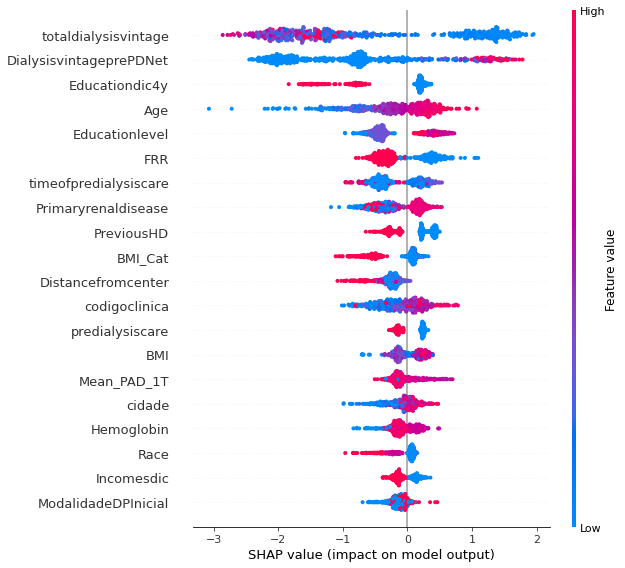

(571, 42)


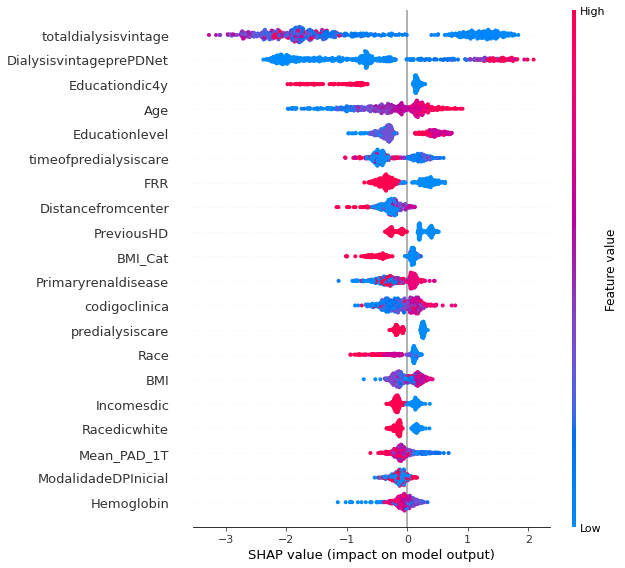

(571, 42)


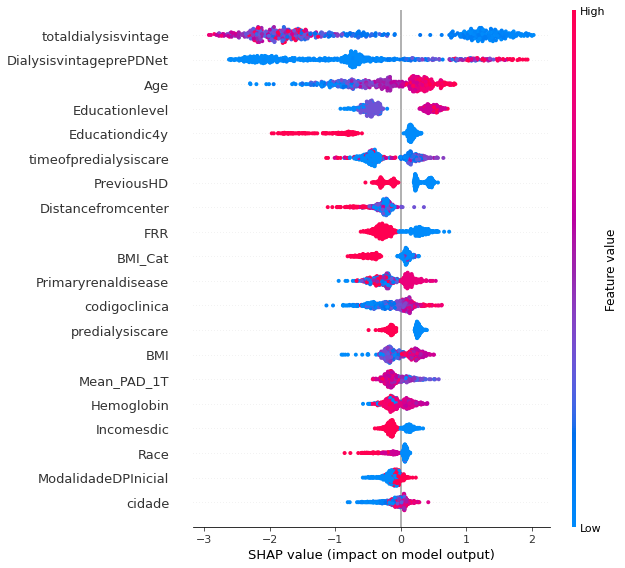

(571, 42)


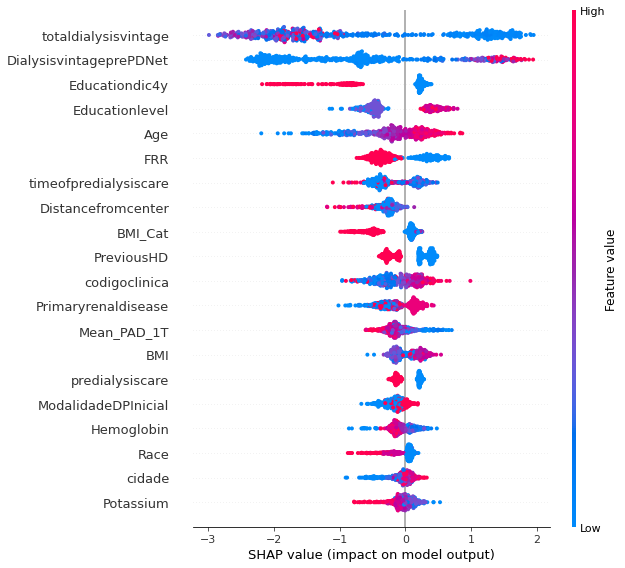

(571, 42)


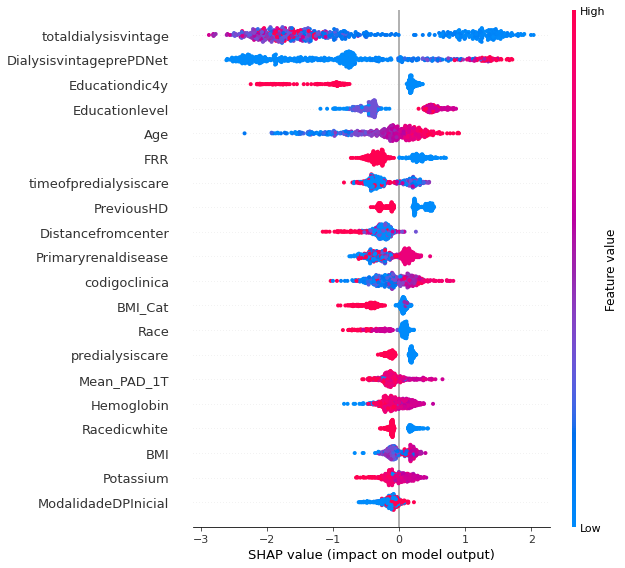

(570, 42)


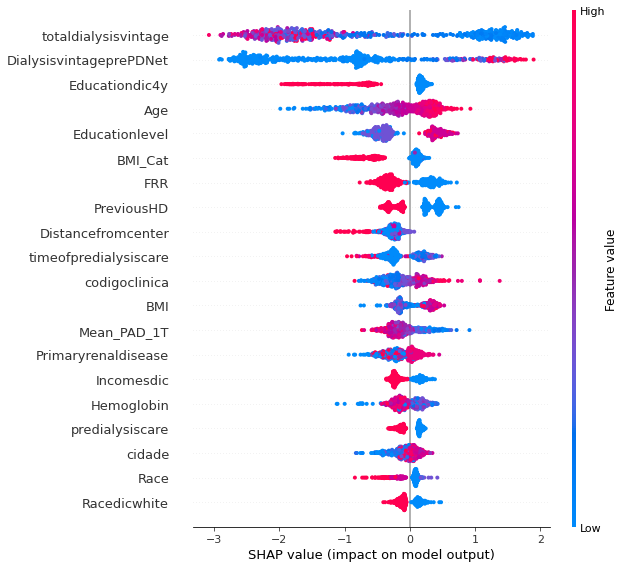

(570, 42)


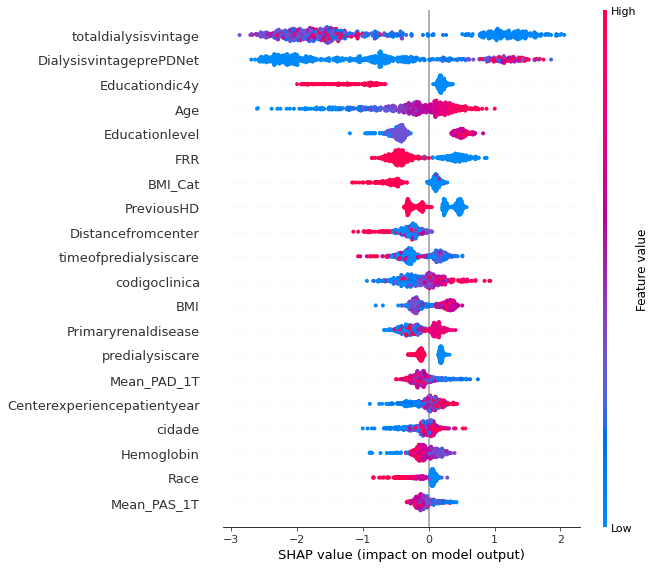

(570, 42)
Target: death_event_1y, mean accuracy: 0.9076578486496452, mean f1-score: 0.325551937640964,            mean recall-score: 0.2539969834087481, mean precision-score:0.46800604985480654


In [200]:
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X[relevant_features].copy()
    print(X_model.shape)
    _,_,_,_ = run_model(X_model,y,use_smote=True)

# Adding timeseries information

In [201]:
timeseries_names = ['Ureia', 'Creatinine', 'TGP',
                    'Potassium', 'Calcium', 'Phosphate',
                    'Glucose', 'Hemoglobin', 'Hematocrit',
                    'Volume_Total', 'Systolic', 'Diastolic',
                    'N_AH_', 'PAS', 'PAD', 'Uso_de_anti_hipert',
                    'inibidor']

expanded_features = []
expanded_features[:] = relevant_features[:] 

for timeseries in timeseries_names:
    for i in range(1,6):
        expanded_features.append(timeseries+str(i))

In [202]:
accum_relevance = Counter()
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X[expanded_features].copy()
    
    X_model.fillna(0,inplace=True)
    print(X_model.shape)
    for train_index, test_index in kf.split(X_model,y):
            X_train, X_test = X_model.iloc[train_index,:], X_model.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]
            X_train = pd.DataFrame(X_train,columns=X_train.columns)
            X_test = pd.DataFrame(X_test,columns=X_test.columns)
    
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            
            clf = xgboost.XGBClassifier(
                learning_rate =0.1,
                max_depth=8,
                min_child_weight=5)
            clf.fit(X_train, y_train)

            model2 = SelectFromModel(clf, prefit=True)
            
            importances = zip(list(X_train.columns),clf.feature_importances_)
            for feat_name, feat_imp in importances:
                accum_relevance[feat_name]+=feat_imp

relevant_features2 = [a for a,b in accum_relevance.items() if b > 0.01]
print(relevant_features2)

(5707, 127)
['Hemoglobin', 'Potassium', 'Phosphate', 'Mean_PAS_1T', 'Mean_PAD_1T', 'FRR', 'codigoclinica', 'ModalidadeCAPD0APD1Mix2', 'CenterSizenpatients', 'ModalidadeDPInicial', 'Age', 'BMI', 'DialysisvintageprePDNet', 'totaldialysisvintage', 'Educationlevel', 'Primaryrenaldisease', 'PreviousHD', 'DaviesScore', 'Peripheralarterydisease', 'DM', 'CAD', 'LVH', 'Hypertension', 'Gender', 'Race', 'Familyincome', 'Distancefromcenter', 'predialysiscare', 'timeofpredialysiscare', 'Agedic65', 'Racedicwhite', 'Educationdic4y', 'Daviesdic', 'Incomesdic', 'Region', 'Centerexperiencepatientyear', 'Regionsdic', 'cidade', 'BMI_Cat', 'BMI_dic', 'Ureia1', 'Ureia2', 'Ureia3', 'Ureia4', 'Ureia5', 'Creatinine1', 'Creatinine2', 'Creatinine3', 'Creatinine4', 'Creatinine5', 'TGP1', 'TGP2', 'TGP3', 'TGP4', 'TGP5', 'Potassium1', 'Potassium2', 'Potassium3', 'Potassium4', 'Potassium5', 'Calcium1', 'Calcium2', 'Calcium3', 'Calcium4', 'Calcium5', 'Phosphate1', 'Phosphate2', 'Phosphate3', 'Phosphate4', 'Phosphate5

(5707, 127)


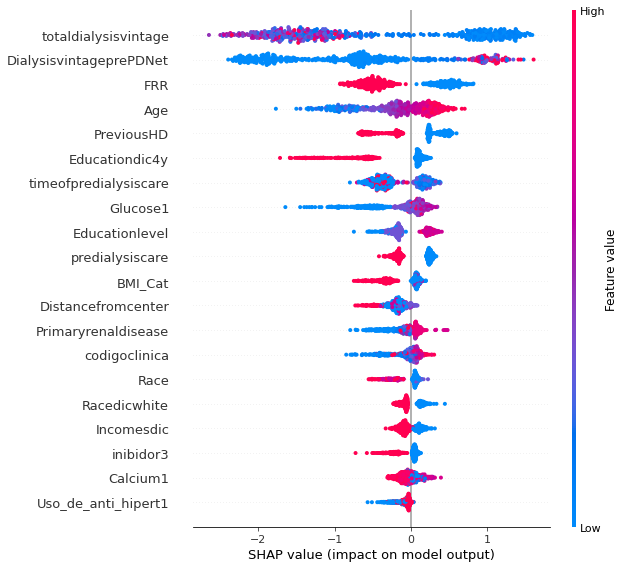

(571, 127)


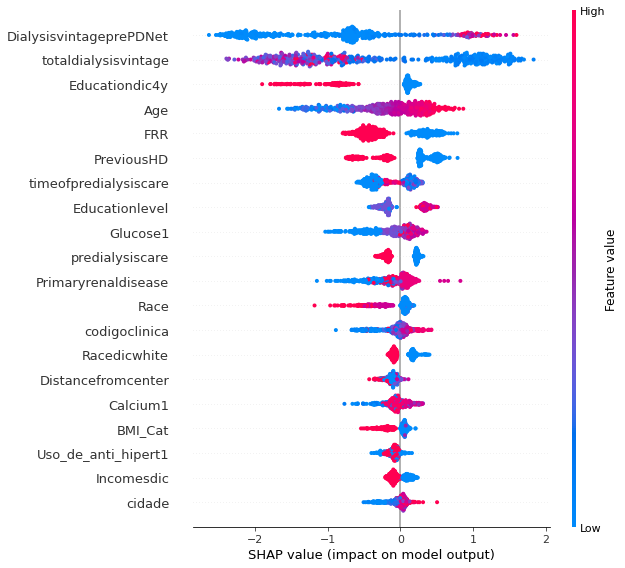

(571, 127)


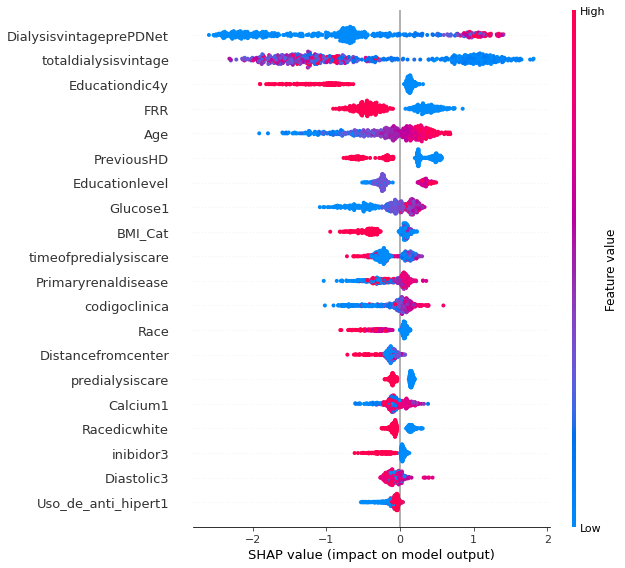

(571, 127)


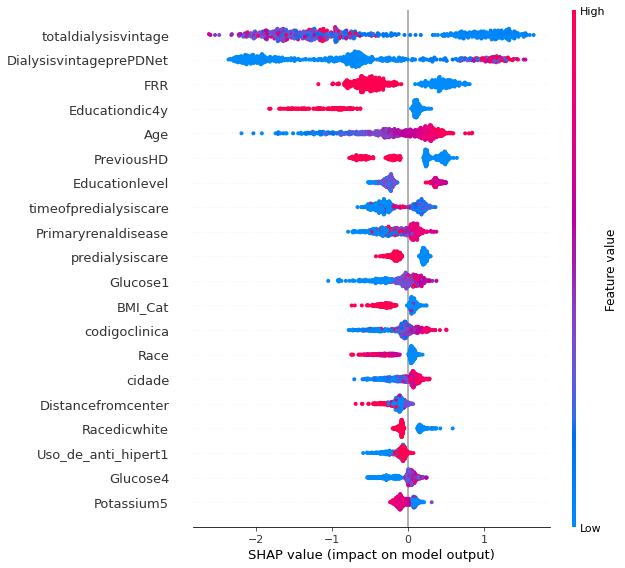

(571, 127)


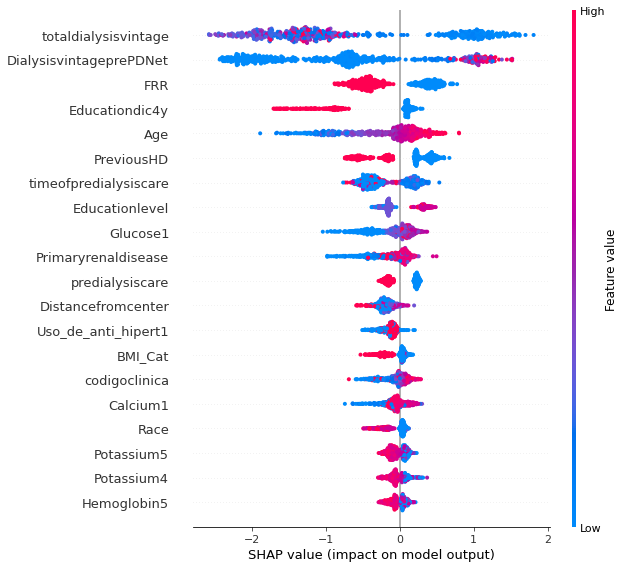

(571, 127)


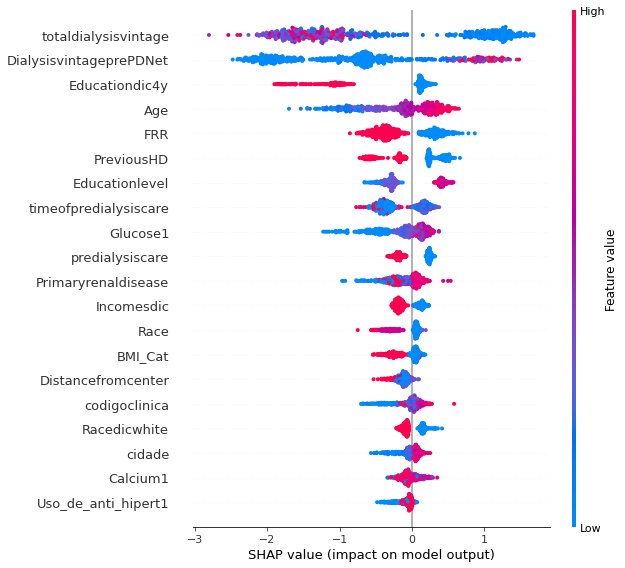

(571, 127)


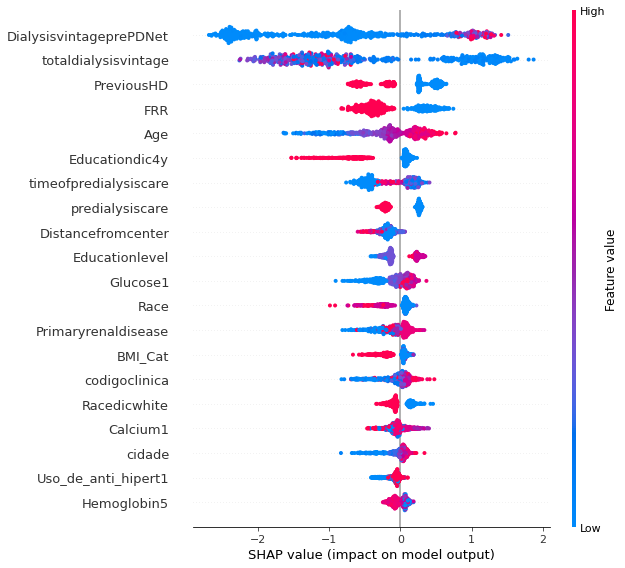

(571, 127)


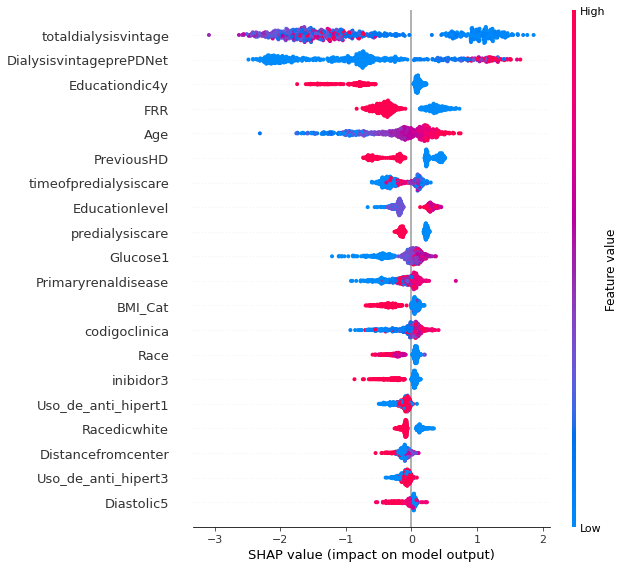

(570, 127)


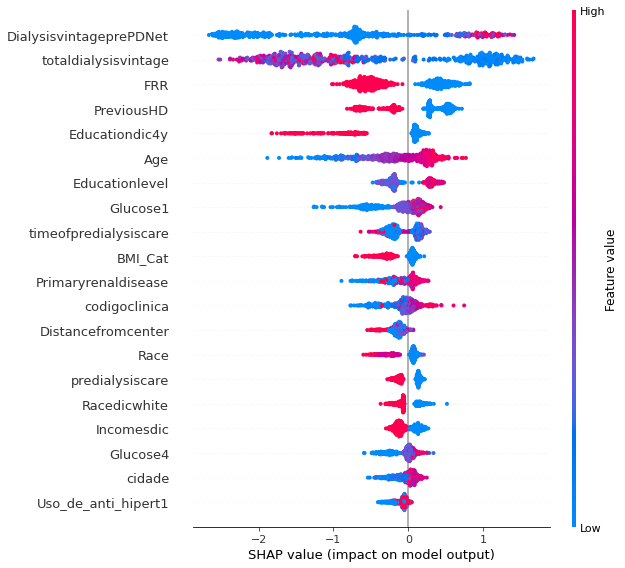

(570, 127)


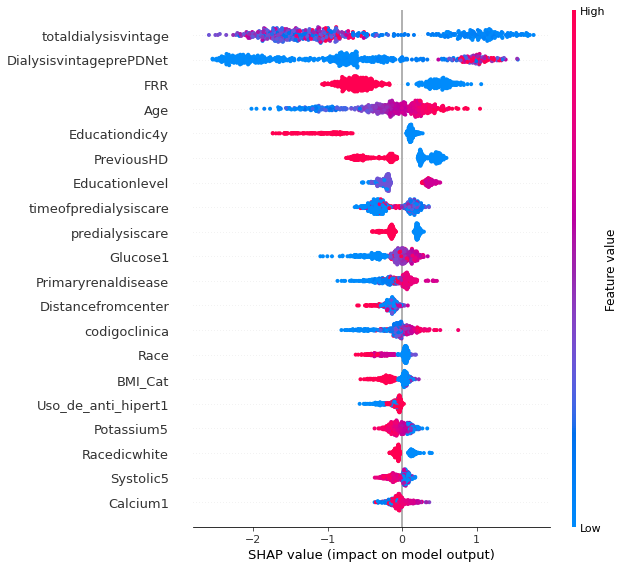

(570, 127)
Target: death_event_1y, mean accuracy: 0.91239131102713, mean f1-score: 0.3152265032472815,            mean recall-score: 0.22869532428355957, mean precision-score:0.5184706163401815


In [203]:
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X[expanded_features].copy()
    print(X_model.shape)
    _,_,_,_ = run_model(X_model,y,use_smote=True)

# Feature Selection and Combination

In [204]:
timeseries_names = ['Ureia', 'Creatinine', 'TGP',
                    'Potassium', 'Calcium', 'Phosphate',
                    'Glucose', 'Hemoglobin', 'Hematocrit',
                    'Volume_Total', 'Systolic', 'Diastolic',
                    'N_AH_', 'PAS', 'PAD', 'Uso_de_anti_hipert',
                    'inibidor']

expanded_features = []
expanded_features[:] = relevant_features[:] 
n_months = 2

for timeseries in timeseries_names:
    j = 1
    columns_to_average = []
    for i in range(3,9):        
        columns_to_average.append(timeseries+str(i))
        if len(columns_to_average) % n_months == 0:
            X[timeseries+'_avg_t'+str(j)] =  pd.Series(X[columns_to_average].mean(axis=1))
            expanded_features.append(timeseries+'_avg_t'+str(j))
            
            j = j + 1
            columns_to_average = []
            

(5707, 93)


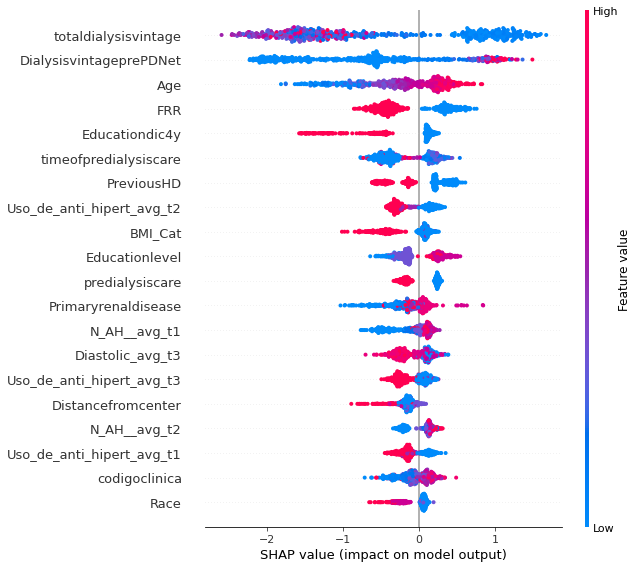

(571, 93)


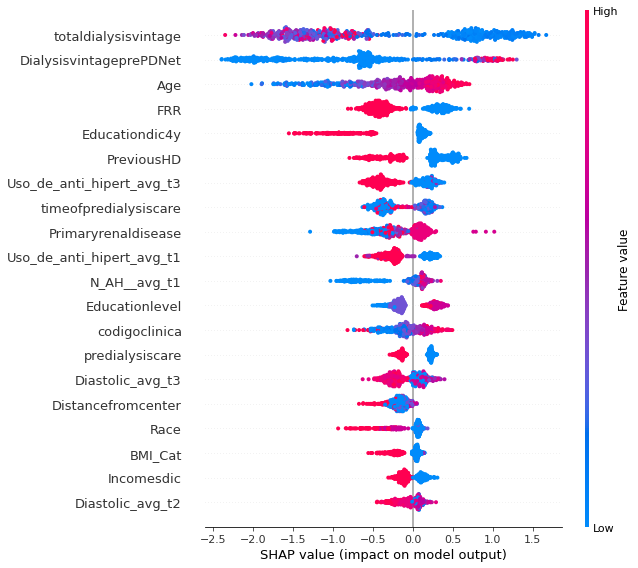

(571, 93)


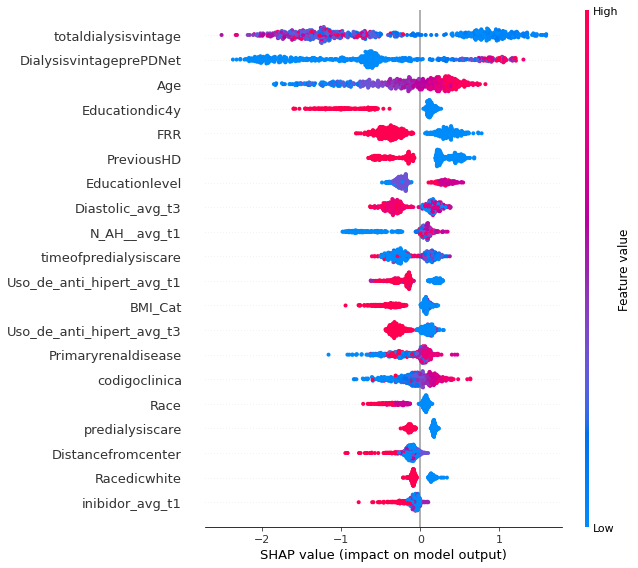

(571, 93)


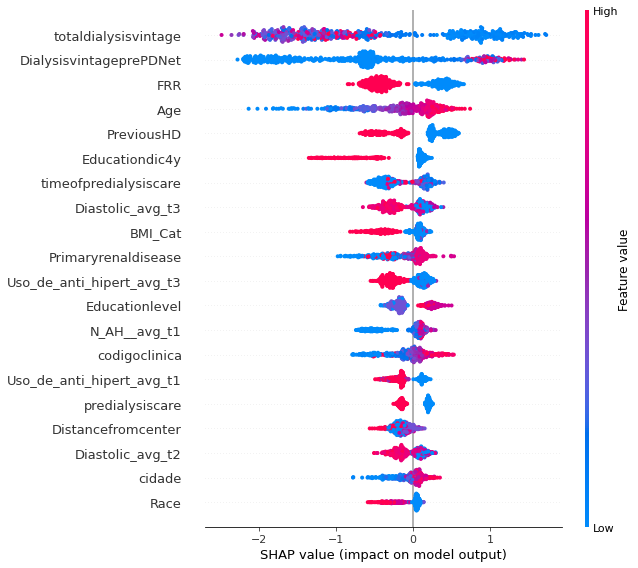

(571, 93)


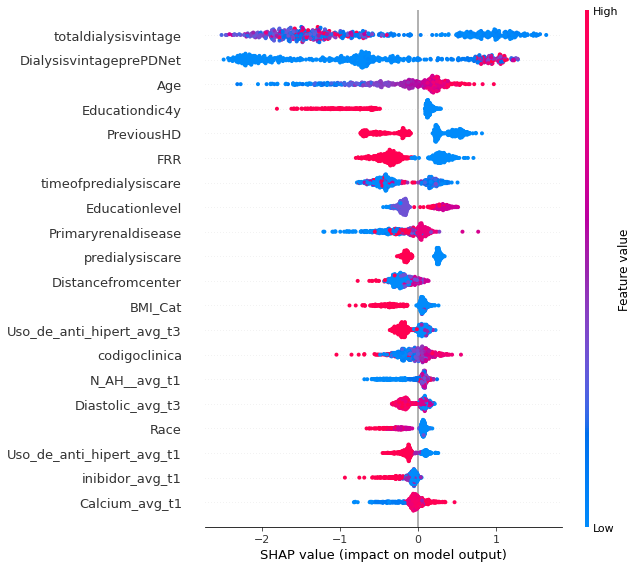

(571, 93)


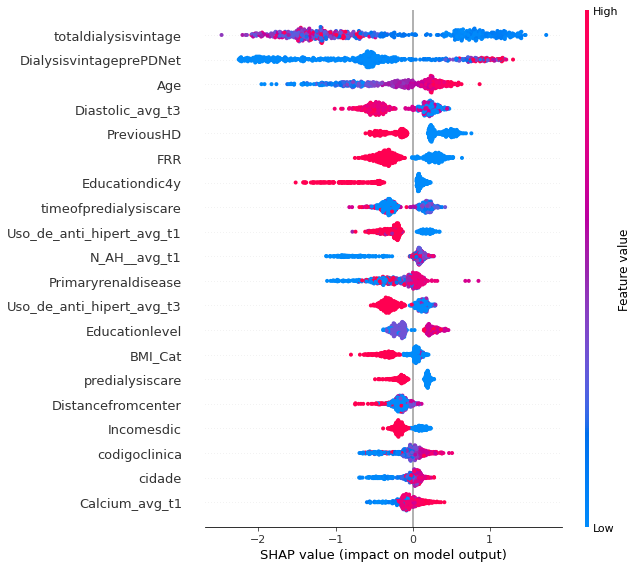

(571, 93)


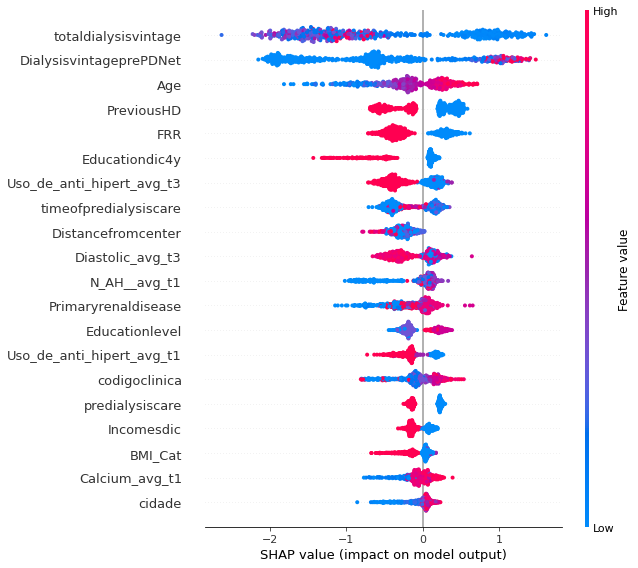

(571, 93)


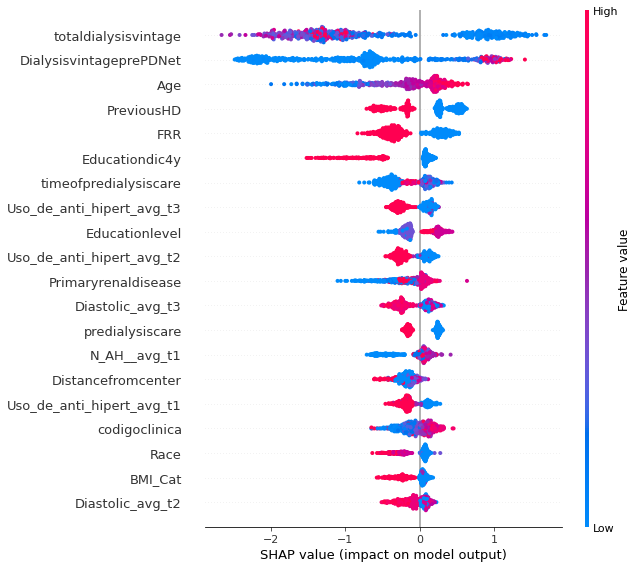

(570, 93)


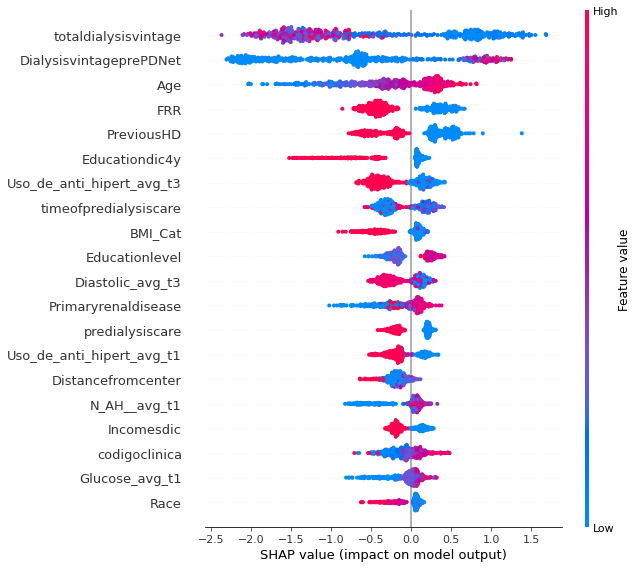

(570, 93)


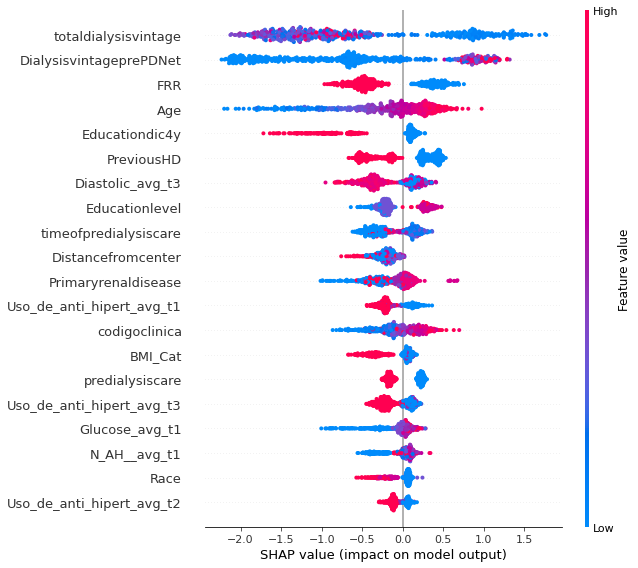

(570, 93)
Target: death_event_1y, mean accuracy: 0.9108105201708299, mean f1-score: 0.3172568816638312,            mean recall-score: 0.2322021116138763, mean precision-score:0.5073783762612285


In [205]:
for target in targets:
    # full dataset
    y = Y[target] 
    X_model = X[expanded_features].copy()
    print(X_model.shape)
    _,_,_,_ = run_model(X_model,y,use_smote=True)

# Federated learning

AxesSubplot(0.125,0.125;0.775x0.755)


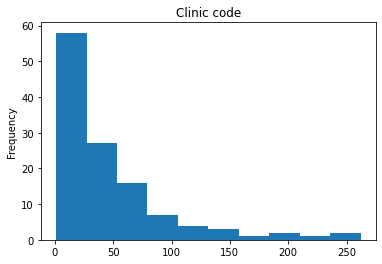

In [206]:
plt.title("Clinic code")
print(X['codigoclinica'].value_counts().plot.hist())

In [ ]:
df_selected = df[unique_cols]
# display(df_selected)

Group_p1 = []
Ms10ou_p1 = []

storage_p1 = [Group_p1, Ms10ou_p1]

Mean_PAS_p1 = []
Mean_PAD_p1 = []

Mean_PAS_p2 = []
Mean_PAD_p2 = []

storage_p2 = [Mean_PAS_p1, Mean_PAD_p1, Mean_PAS_p2, Mean_PAD_p2]

Ureia = dict()
Creatinine = dict()
TGP = dict()
Potassium = dict()
Calcium = dict()
Phosphate = dict()
Glucose = dict()
Hemoglobin = dict()
Hematocrit = dict()
Volume_Total = dict()
Systolic = dict()
Diastolic = dict()


label_dict = [Ureia, Creatinine, TGP, Potassium, Calcium, Phosphate, Glucose, 
              Hemoglobin, Hematocrit, Volume_Total, Systolic, Diastolic]

label_str = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
              'Hemoglobin', 'Hematocrit','Volume_Total', 'N_AH', 'Systolic', 'Diastolic']

label_idx = 0

for item in label_dict:
    for i in range(13):
        key = 'p'+str(i+1)
        item[key] = []
    label_idx = label_idx + 1
    
label_idx = 0    
for item in label_dict:
    count = 0
    section = 1
    labelname = label_str[label_idx]
    for col in timeseries_cols:
        if labelname in col:
            if count < 6:
                count = count + 1
            else:
                section = section + 1
                count = 1
            key = 'p'+str(section)
            item[key].append(col)
    label_idx = label_idx + 1

indices_p1 = ['Group', 'Ms10ou']

indices_p2 = ['Mean_PAS', 'Mean_PAD']



# Select certain features as 1 section
for col in timeseries_cols:
    i = 0
    for idx in indices_p1:
        if idx in col:
            storage_p1[i].append(col)
        i = i + 1
# print(storage_p1)

# Separate certain features to 2 sections (each section contains 4 features)
i = 0 # i is the index of feature name
for idx in indices_p2:
    p = 0
    count = 0
    for col in timeseries_cols:
        if idx in col:
            if count < 4:
                storage_p2[i+2*p].append(col)
                count = count + 1
            else:
                count = 0
                p = p + 1
                storage_p2[i+2*p].append(col)
                count = count + 1
    i = i + 1

for i in range(len(indices_p1)):
    df_selected.loc[:,indices_p1[i]] = df[storage_p1[i]].mean(axis=1)

for i in range(len(indices_p2)):
    for p in range(2):
        name = indices_p2[i] + '_p' + str(p+1)
        df_selected.loc[:,name] = df[storage_p2[i+2*p]].mean(axis=1)       

label_idx = 0
for item in label_dict:
    for p in range(13):
        name = label_str[label_idx] + '_p' + str(p+1)
        df_selected.loc[:,name] = df[item['p'+str(p+1)]].mean(axis=1)
    label_idx = label_idx + 1
        
    
df_selected = df_selected.fillna(0)
display(df_selected)


In [ ]:
from matplotlib import pyplot as plt

plt.figure()
df_selected['Deathevent'].plot.hist()

plt.figure()
df_selected[df_selected['Deathevent']==1]["Causeofdeath"].plot.hist()

plt.figure()
df_selected['TechniqueFailureevent'].plot.hist()

plt.figure()
df_selected[df_selected['TechniqueFailureevent']==1]["Causeofdropout"].plot.hist()

# Predicting binary outcomes:

* Deathevent   
* TechniqueFailureevent

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold

targets = ["Deathevent","TechniqueFailureevent"]

models = []

for target in targets:
    # full dataset
    base_data = df_selected 

    y = base_data[target] 
    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y" ]) # X is based on patients' personal information
    
    # apply k-fold cross validation
    k = 5
    kf = StratifiedKFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    j = 0
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test = pd.DataFrame(X_test,columns=X.columns)
        
        # train XGBoost model
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=8,
            min_child_weight=5)
        model.fit(X_train, y_train)
        
        # use saved model
#         filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
#         j = j + 1
#         model = pickle.load(open(filename, 'rb'))
        
        
        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
        recallscore = recall_score(y_test,y_pred)
        precisionscore = precision_score(y_test,y_pred)
        print(f"F1 score: {f1score}")
#         shap.summary_plot(shap_values, X_test)
#         print(shap_values.shape)
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        
    #bringing back variable names    
    X_test = X.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")
    
    shap.summary_plot(shap_values, X_test)


In [ ]:
# Save predictive models
import pickle

i = 0
model = None
for target in targets:
    for j in range(k):
        filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
        model = models[i * k + j]
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
    i = i + 1

# Predicting multiclass outcomes:

* Causeofdeath   
* Causeofdropout

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

targets = ["Causeofdeath","Causeofdropout"]
indicators = {"Causeofdeath":"Deathevent","Causeofdropout":"Dropoutsim1"}

models = []

for target in targets:
    base_data = df_selected[df_selected[indicators[target]]==1]

    y = base_data[target] 
    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y" ]) # X is based on patients' personal information
    # apply k-fold cross validation
    k = 5
    kf = KFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    j = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test = pd.DataFrame(X_test,columns=X.columns)
        
        # train XGBoost model
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=9,
            min_child_weight=4)
        model.fit(X_train, y_train)
        
        # use saved model
#         filename = 'models/' + target + '_fold'+ str(j) + '_multiclass_model.pkl'
#         j = j + 1
#         model = pickle.load(open(filename, 'rb'))
        
        
        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred, average='micro')
#         print(f"F1 score: {f1score}")
#         shap.summary_plot(shap_values, X_test)
#         shap_values = np.array(shap_values)
#         print(shap_values.shape)
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
    new_shap_values = list()
    for i in range(shap_values.shape[0]):
        new_shap_values.append(shap_values[i])
    
        
    #bringing back variable names    
    X_test = X.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")
    
    shap.summary_plot(new_shap_values, X_test)
    
#     # Split data into train and test subsets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, shuffle=True, random_state=None)
    
#     # Train XGBoost model
#     model = xgboost.XGBClassifier(
#         learning_rate =0.1,
#         max_depth=9,
#         min_child_weight=4)
#     model.fit(X_train, y_train)
    
#     # Use saved models
# #     filename = 'models/' + target + '_multiclass_model.pkl'
# #     model = pickle.load(open(filename, 'rb')) 

#     models.append(model)

#     y_pred = model.predict(X_test)
#     normalised_accuracy = accuracy_score(y_test, y_pred)

#     print(f"Target: {target}, accuracy: {normalised_accuracy}")
    
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)
#     print(shap_values.shape)
#     print(X_test.shape)

#     shap.summary_plot(shap_values, X_test)

In [ ]:
# Save predictive models
import pickle

i = 0
model = None
for target in targets:
    for j in range(k):
        filename = 'models/' + target + '_fold'+ str(j) + '_multiclass_model.pkl'
        model = models[i * k + j]
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
    i = i + 1

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

targets = ["Causeofdeath","Causeofdropout"]
indicators = {"Causeofdeath":"Deathevent","Causeofdropout":"Dropoutsim1"}

models = []
classnumlist = []

for target in targets:
    base_data = df_selected[df_selected[indicators[target]]==1]

    y = base_data[target] 
    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y" ]) # X is based on patients' personal information
    
    set1 = set(y)
    classnumlist.append(set1)
    
    for classidx in set1:
        # Create binary classification labels
        y = np.array(y)
        ybi = np.zeros(y.shape)
        for i in range(len(y)):
            if y[i] == classidx:
                ybi[i] = 1
            else:
                ybi[i] = -1
        
        # apply k-fold cross validation
        k = 5
        kf = KFold(n_splits=k,shuffle=True,random_state=1)

        list_shap_values = list()
        list_test_sets = list()
        list_normalised_accuracy = list()
        list_f1_score = list()
        j = 0

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = ybi[train_index], ybi[test_index]
            X_train = pd.DataFrame(X_train,columns=X.columns)
            X_test = pd.DataFrame(X_test,columns=X.columns)

            # train XGBoost model
            model = xgboost.XGBClassifier(
                learning_rate =0.1,
                max_depth=9,
                min_child_weight=4)
            model.fit(X_train, y_train)

            # use saved model
#             filename = 'models/' + target + '_class' + str(classidx) + '_fold'+ str(j) + '_binary_model.pkl'
#             j = j + 1
#             model = pickle.load(open(filename, 'rb'))


            # explaining model
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            y_pred = model.predict(X_test)
            normalised_accuracy = accuracy_score(y_test, y_pred)
            f1score = f1_score(y_test, y_pred)
#             print(f"F1 score: {f1score}")
#             shap.summary_plot(shap_values, X_test)
#             print(shap_values.shape)

            # for each iteration we save the test_set index and the shap_values
            list_shap_values.append(shap_values)
            list_test_sets.append(test_index)
            list_normalised_accuracy.append(normalised_accuracy)
            list_f1_score.append(f1score)
            models.append(model)

        #combining results from all iterations
        test_set = list_test_sets[0]
        shap_values = np.array(list_shap_values[0])
        for i in range(0,len(list_test_sets)):
            test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
            shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)

        #bringing back variable names    
        X_test = X.iloc[test_set,:]

        mean_normalised_accuracy = np.mean(list_normalised_accuracy)
        mean_f1_score = np.mean(list_f1_score)
        
        print(f"Target: {target}, Class: {classidx}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")

        shap.summary_plot(shap_values, X_test)
                
                
                
#         # Split data into train and test subsets
#         X_train, X_test, y_train, y_test = train_test_split(
#             X, ybi, test_size=0.2, shuffle=True, random_state=None)
        
#         # Train XGBoost model
#         model = xgboost.XGBClassifier(
#             learning_rate =0.1,
#             max_depth=9,
#             min_child_weight=4)
#         model.fit(X_train, y_train)
        
            
#         # Use saved models
# #         filename = 'models/' + target + '_class' + str(classidx) + '_binary_model.pkl'
# #         model = pickle.load(open(filename, 'rb')) 
        
        
#         models.append(model)

#         y_pred = model.predict(X_test)
#         normalised_accuracy = accuracy_score(y_test, y_pred)
        
#         print("Binary classification for Class",classidx)
#         print(f"Target: {target}, accuracy: {normalised_accuracy}")

#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(X_test)

#         shap.summary_plot(shap_values, X_test)

In [ ]:
# Save predictive models
import pickle

i = 0
j = 0
model = None
for target in targets:
    classnum = classnumlist[i]
    for classidx in classnum:
        for ik in range(k):         
            filename = 'models/' + target + '_class' + str(classidx) + '_fold' + str(ik) + '_binary_model.pkl'
            model = models[j]
            with open(filename, 'wb') as file:  
                pickle.dump(model, file)
            j = j + 1
    i = i + 1

# Predicting binary outcomes for events in different years:


* death_event_1y
* Followup1y
* Tech_event_1y
* death_event_2y
* Followup2y
* Tech_event_2y
* death_event_3y
* Followup3y
* Tech_event_3y

In [ ]:
Ureia = dict()
Creatinine = dict()
TGP = dict()
Potassium = dict()
Calcium = dict()
Phosphate = dict()
Glucose = dict()
Hemoglobin = dict()
Hematocrit = dict()
Volume_Total = dict()
Systolic = dict()
Diastolic = dict()


label_dict = [Ureia, Creatinine, TGP, Potassium, Calcium, Phosphate, Glucose, 
              Hemoglobin, Hematocrit, Volume_Total, Systolic, Diastolic]

label_str = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
              'Hemoglobin', 'Hematocrit','Volume_Total', 'N_AH', 'Systolic', 'Diastolic']

label_idx = 0

for item in label_dict:
    for i in range(26):
        key = 'p'+str(i+1)
        item[key] = []
    label_idx = label_idx + 1
    
label_idx = 0    
for item in label_dict:
    count = 0
    section = 1
    labelname = label_str[label_idx]
    for col in timeseries_cols:
        if labelname in col:
            if count < 3:
                count = count + 1
            else:
                section = section + 1
                count = 1
            key = 'p'+str(section)
            item[key].append(col)
    label_idx = label_idx + 1

dfs = [df[unique_cols], df[unique_cols], df[unique_cols]]



extra_1y = ['Mean_PAS_1T', 'Mean_PAD_1T']
extra_2y = ['Mean_PAS_3T', 'Mean_PAD_3T']
extra_3y = ['Mean_PAS_5T', 'Mean_PAD_5T']
extras = [extra_1y, extra_2y, extra_3y]

for year in range(3):
    for index in extras[year]:
            dfs[year].loc[:,index] = df[index]    
    dfs[year] = dfs[year].fillna(0)

display(list(dfs[0].columns))

In [ ]:
print(list(dfs[0].columns))

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

targets = ["death_event_1y"]#,"Followup1y","Tech_event_1y"]

models = []

for target in targets:
    # full dataset
    base_data = dfs[0].copy()

    if target == "Followup1y":
        temp = base_data[target]
        y = []
        for it in temp:
            if it > 0:
                y.append(1)
            else:
                y.append(0)
        y = pd.DataFrame(y)
    else:
        y = base_data[target]   
    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y",'Id' ]) # X is based on patients' personal information
    print(X.columns)
    # apply k-fold cross validation
    k = 10
    kf = StratifiedKFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    j = 0
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test = pd.DataFrame(X_test,columns=X.columns)
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # train XGBoost model
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=8,
            min_child_weight=3)
        model.fit(X_train, y_train)
        
        # use saved model
#         filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
#         j = j + 1
#         model = pickle.load(open(filename, 'rb'))
        
        
        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
        recallscore = recall_score(y_test,y_pred)
        precisionscore = precision_score(y_test,y_pred)
        print(f"F1 score: {f1score} Recall: {recallscore} Precision: {precisionscore}")
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        
    #bringing back variable names    
    X_test = X.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")
    
    shap.summary_plot(shap_values, X_test)


In [ ]:
# Save predictive models
import pickle

i = 0
model = None
for target in targets:
    for j in range(k):
        filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
        model = models[i * k + j]
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
    i = i + 1

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

targets = ["death_event_2y","Followup2y","Tech_event_2y"]

models = []

for target in targets:
    # full dataset
    base_data = dfs[1].copy()
    if target == "death_event_2y":
        indexNames = df[df["death_event_1y"] == 1].index
    elif target == "Tech_event_2y":
        indexNames = df[df["Tech_event_1y"] == 1].index
    else:
        indexNames = df[df["Followup1y"] == 0].index
    base_data.drop(indexNames , inplace=True) 
    
    if target == "Followup2y":
        temp = base_data["Followup2y"] - base_data["Followup1y"]
        y = []
        for it in temp:
            if it > 0:
                y.append(1)
            else:
                y.append(0)
        y = pd.DataFrame(y)
    else:
        y = base_data[target]
        
    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y" ]) # X is based on patients' personal information
    
    # apply k-fold cross validation
    k = 5
    kf = KFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    j = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test = pd.DataFrame(X_test,columns=X.columns)
        
        # train XGBoost model
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=8,
            min_child_weight=3)
        model.fit(X_train, y_train)
        
        # use saved model
#         filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
#         j = j + 1
#         model = pickle.load(open(filename, 'rb'))
        
        
        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
#         print(f"F1 score: {f1score}")
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        
    #bringing back variable names    
    X_test = X.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")
    
    shap.summary_plot(shap_values, X_test)
    
#     # Split data into train and test subsets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, shuffle=True, random_state=None)
    
#     # Train XGBoost model
#     model = xgboost.XGBClassifier(
#         learning_rate =0.1,
#         max_depth=8,
#         min_child_weight=3)
#     model.fit(X_train, y_train)
    
#     # Use saved models
# #     filename = 'models/' + target + '_binary_model.pkl'
# #     model = pickle.load(open(filename, 'rb'))   

#     models.append(model)

#     y_pred = model.predict(X_test)
#     normalised_accuracy = accuracy_score(y_test, y_pred)

#     print(f"Target: {target}, accuracy: {normalised_accuracy}")
    
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)

#     shap.summary_plot(shap_values, X_test)

In [ ]:
# Save predictive models
import pickle

i = 0
model = None
for target in targets:
    for j in range(k):
        filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
        model = models[i * k + j]
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
    i = i + 1

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

targets = ["death_event_3y","Followup3y","Tech_event_3y"]

models = []

for target in targets:
    # full dataset
    base_data = dfs[2].copy()
    if target == "death_event_3y":
        indexNames = df[(df["death_event_1y"] == 1) | (df["death_event_2y"] == 1)].index
    elif target == "Tech_event_3y":
        indexNames = df[(df["Tech_event_1y"] == 1) | (df["Tech_event_2y"] == 1)].index
    else:
        indexNames = df[(df["Followup1y"] == 0) | (df["Followup2y"] - df["Followup1y"] == 0)].index
    base_data.drop(indexNames , inplace=True)
    
    if target == "Followup3y":
        temp = base_data["Followup3y"] - base_data["Followup2y"]
        y = []
        for it in temp:
            if it > 0:
                y.append(1)
            else:
                y.append(0)
        y = pd.DataFrame(y)
    else:
        y = base_data[target]

    X = base_data.drop(columns=['Deathevent', 'Causeofdeath',\
                                'TechniqueFailureevent', 'nome_cidade',\
                                'DataincioPDNEt','TechFailureDeathnotcens',\
                                'CRTechniqueFailure','CRDeath',\
                                'Causeofdropout','Dropoutsim1',\
                                'Anodesada','mesdesaida','anodeentrada',\
                                'CODPAX','Bienium','Followup','Followup1y',\
                                'Followup2y','Followup3y',"death_event_1y",\
                                "Tech_event_1y","death_event_2y","Tech_event_2y",\
                                "death_event_3y","Tech_event_3y" ]) # X is based on patients' personal information
    
    # apply k-fold cross validation
    k = 5
    kf = KFold(n_splits=k,shuffle=True,random_state=1)

    list_shap_values = list()
    list_test_sets = list()
    list_normalised_accuracy = list()
    list_f1_score = list()
    j = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=X.columns)
        X_test = pd.DataFrame(X_test,columns=X.columns)
        
        # train XGBoost model
        model = xgboost.XGBClassifier(
            learning_rate =0.1,
            max_depth=8,
            min_child_weight=3)
        model.fit(X_train, y_train)
        
        # use saved model
#         filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
#         j = j + 1
#         model = pickle.load(open(filename, 'rb'))
        
        
        # explaining model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        y_pred = model.predict(X_test)
        normalised_accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)
#         print(f"F1 score: {f1score}")
        
        # for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        list_test_sets.append(test_index)
        list_normalised_accuracy.append(normalised_accuracy)
        list_f1_score.append(f1score)
        models.append(model)
    
    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(0,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        
    #bringing back variable names    
    X_test = X.iloc[test_set,:]
    
    mean_normalised_accuracy = np.mean(list_normalised_accuracy)
    mean_f1_score = np.mean(list_f1_score)
    print(f"Target: {target}, mean accuracy: {mean_normalised_accuracy}, mean f1-score: {mean_f1_score}")
    
    shap.summary_plot(shap_values, X_test)
    
#     # Split data into train and test subsets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, shuffle=True, random_state=None)
    
#     # Train XGBoost model
#     model = xgboost.XGBClassifier(
#         learning_rate =0.1,
#         max_depth=8,
#         min_child_weight=3)
#     model.fit(X_train, y_train)
    
#     # Use saved models
# #     filename = 'models/' + target + '_binary_model.pkl'
# #     model = pickle.load(open(filename, 'rb'))   

#     models.append(model)

#     y_pred = model.predict(X_test)
#     normalised_accuracy = accuracy_score(y_test, y_pred)

#     print(f"Target: {target}, accuracy: {normalised_accuracy}")
    
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)

#     shap.summary_plot(shap_values, X_test)

In [ ]:
# Save predictive models
import pickle

i = 0
model = None
for target in targets:
    for j in range(k):
        filename = 'models/' + target + '_fold'+ str(j) + '_binary_model.pkl'
        model = models[i * k + j]
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
    i = i + 1